# Visualizing Spectra with SIMPLE 

### Brief Overview of Querying SIMPLE

##### To better understand querying, we recommend you run through the QueryDemo.ipynb notebook before you begin here. Once you feel ready regarding querying, come back here for some fun with visualization. 

##### In this notebook, we will mostly use the AstroDBUtils package to query the database. Find more information on this package here: https://astrodbkit.readthedocs.io/en/latest/#exploring-the-schema

In [1]:
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from specutils import Spectrum

from sqlalchemy import and_, or_
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
plt.rcParams['font.family'] = 'serif'

In [2]:
# Load in the database
from astrodb_utils import load_astrodb
from simple import REFERENCE_TABLES

SCHEMA_PATH = "simple/schema.yaml" 
db = load_astrodb(
     "SIMPLE.sqlite", 
     recreatedb=False,  
     reference_tables=REFERENCE_TABLES, 
     felis_schema=SCHEMA_PATH
     )

In [20]:
# Query the total number of objects within SIMPLE
print(f"Total number of objects in the SIMPLE database: {db.query(db.Sources).count()} \n")

# Query for WISE objects within SIMPLE
wise_sources_query = "SELECT * FROM Sources WHERE source LIKE '%WISE%'"
print(f"Total number of WISE objects in the SIMPLE database: {len(db.sql_query(wise_sources_query))} \n")
print("First Five WISE Sources:")
db.sql_query(wise_sources_query, fmt='astropy')[:5]

Total number of objects in the SIMPLE database: 3619 

Total number of WISE objects in the SIMPLE database: 616 

First Five WISE Sources:


source,ra,dec,epoch,equinox,shortname,reference,other_references,comments
str27,float64,float64,object,object,object,str11,object,object
CWISEP J230158.30-645858.3,345.4929166666666,-64.98286111111112,None,None,None,Meis20.74,None,None
WISE J200403.17-263751.7,301.013,-26.6293,None,2000,None,Thom13,None,None
WISEA J012834.87-280302.5,22.145291666666665,-28.050694444444446,None,None,None,Meis20.123,None,None
WISE J235402.77+024015.0,358.5116543,2.6705854,None,None,2354+0240,Schn15,None,None
WISEA J001450.17-083823.4,3.7046,-8.639,None,2000,None,Kirk14,None,None


### Visualization Methods

#### Lets first try plotting multiple spectra from a single source.

In [ ]:
spectra_query = "SELECT * FROM Spectra WHERE Source LIKE '%2MASS J0415%'"
spectra_results = db.sql_query(spectra_query)

print(f"Found {len(spectra_results)} spectra matching the query.")

nir_spectra = []
for spec in spectra_results:
    if 'nir' in spec[4].lower():
        if "SpeX" not in spec[6]: # Exclude SpeX spectra
            nir_spectra.append(spec)

print(f'Found {len(nir_spectra)} NIR spectra for the source.\n')

# Display the NIR spectra details
print("NIR Spectra Details:")
for i, spectra in enumerate(nir_spectra):
    print(i, spectra)

Found 9 spectra matching the query.
Found 3 NIR spectra for the source.

NIR Spectra Details:
0 ('2MASS J04151954-0935066', 'https://bdnyc.s3.us-east-1.amazonaws.com/FIRE/FIRE_0415-0935.fits', None, None, 'nir', 'Magellan I Baade', 'FIRE', 'Echelle', '2010-09-20 00:00:00.000000', None, 'Alej25', None)
1 ('2MASS J04151954-0935066', 'https://bdnyc.s3.us-east-1.amazonaws.com/JWST/NIRSpec/jw02124-o059_s00001_nirspec_f290lp-g395h-s200a1-subs200a1_x1d_manual.fits', None, None, 'nir', 'JWST', 'NIRSpec', 'F290LP.G395H', '2022-10-16 00:00:00.000000', None, 'Alej25', None)
2 ('2MASS J04151954-0935066', 'https://bdnyc.s3.us-east-1.amazonaws.com/AKARI_2MASS%2BJ04151954-0935066_2007-08-23.fits', None, None, 'nir', 'AKARI', 'IRC', 'IRC04', '2007-08-23 00:00:00.000000', None, 'Sora12', None)


Loading https://bdnyc.s3.us-east-1.amazonaws.com/FIRE/FIRE_0415-0935.fits... 
 Units for wavelength: um, Units for flux: erg / (Angstrom s cm2)
Updated Units for flux: erg / (Angstrom s cm2) 

Loading https://bdnyc.s3.us-east-1.amazonaws.com/JWST/NIRSpec/jw02124-o059_s00001_nirspec_f290lp-g395h-s200a1-subs200a1_x1d_manual.fits... 
 Units for wavelength: um, Units for flux: Jy
Updated Units for flux: erg / (Angstrom s cm2) 

Loading https://bdnyc.s3.us-east-1.amazonaws.com/AKARI_2MASS%2BJ04151954-0935066_2007-08-23.fits... 
 Units for wavelength: um, Units for flux: W / (um m2)
Updated Units for flux: erg / (Angstrom s cm2) 



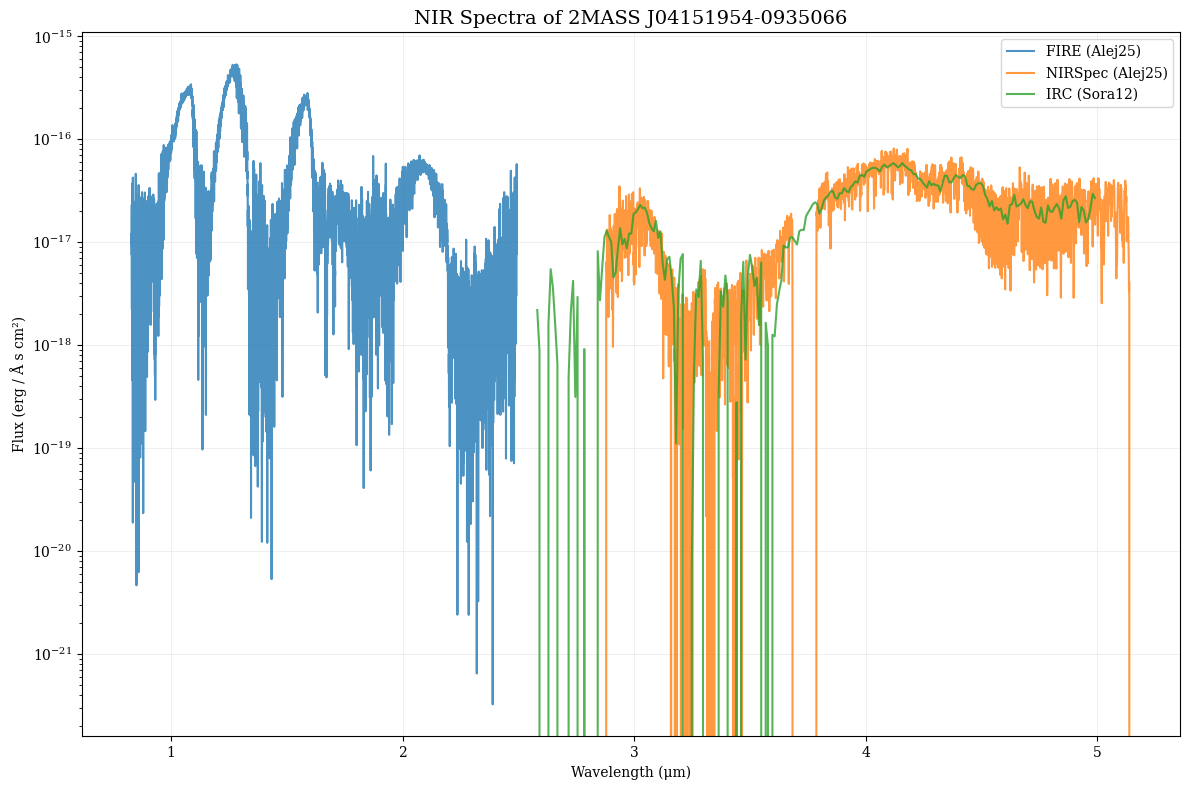

In [ ]:
import astropy.constants as const
from specutils import Spectrum

plt.figure(figsize=(12, 8))
ax = plt.gca()
# Loop through each NIR spectrum and load it
for i, spec_data in enumerate(nir_spectra):
    try:
        # Extract data
        name = spec_data[0]
        url = spec_data[1]
        instrument = spec_data[6] 
        reference = spec_data[10]
        
        # Load the spectrum
        spec = Spectrum.read(url, format='tabular-fits')
        
        # Get wavelength and flux with units
        wavelength = spec.spectral_axis
        flux = spec.flux
        
        print(f"Loading {url}... \n Units for wavelength: {wavelength.unit}, Units for flux: {flux.unit}")
        
        target_unit = u.erg / (u.s * u.cm**2 * u.AA)

        if not flux.unit.is_equivalent(target_unit):
            if flux.unit == u.Jy:
                lam = wavelength.to(u.AA)  
                fnu = flux.to(u.erg / u.s / u.cm**2 / u.Hz)  
                flux = fnu * (const.c.to(u.AA/u.s) / lam**2) 
                flux = flux.to(target_unit)

            elif flux.unit == u.W / (u.um * u.m**2):
                flux = flux.to(target_unit)

        flux = flux.to(target_unit) # Safety conversion in case of other units
                
        print(f"Updated Units for flux: {flux.unit} \n")

        # Plot each spectrum with a unique color and label
        plt.plot(wavelength, flux, label=f"{instrument} ({reference})", alpha=0.8, linewidth=1.5)
        
    except Exception as e:
        print(f"Error: {str(e)}")

# Plot configuration
plt.xlabel("Wavelength (μm)")
plt.ylabel("Flux (erg / Å s cm²)")
plt.title(f"NIR Spectra of {name}", fontsize=14)
plt.grid(True, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
plt.legend(loc='upper right')

plt.yscale('log')

plt.tight_layout()
plt.show()

#### Now lets try plotting spectra from multiple sources using a couple different metrics we can decide on within SIMPLE

##### To further understand what different ways you can query obects you can reference the schema in simple/schema.yaml

In [46]:
# Create a query to join ModeledParameters and Spectra tables
# This will find all spectra for sources with T_eff between 1100-1400K
spectra_temp_query = """
SELECT 
    mp.source, 
    mp.parameter,
    mp.value,
    mp.model, 
    mp.reference as param_reference,
    s.regime, 
    s.instrument, 
    s.telescope, 
    s.reference as spec_reference,
    s.observation_date,
    s.access_url
FROM ModeledParameters mp
JOIN Spectra s ON mp.source = s.source
WHERE mp.parameter = 'T eff' 
    AND mp.value BETWEEN 1100 AND 1400
ORDER BY mp.value, mp.source, s.regime
"""

# Execute the query
print("Querying spectra with T_eff between 1100K and 1400K...")
print(f"Found {len(db.sql_query(spectra_temp_query))} spectra matching the criteria within SIMPLE.")
print(f"Total unique sources with T_eff between 1100K and 1400K: {len(set([row[0] for row in db.sql_query(spectra_temp_query)]))} \n")
low_temp = db.sql_query(spectra_temp_query, fmt='pandas')
print(low_temp)

Querying spectra with T_eff between 1100K and 1400K...
Found 314 spectra matching the criteria within SIMPLE.
Total unique sources with T_eff between 1100K and 1400K: 87 

                       source parameter   value        model param_reference  \
0     2MASS J03255322+0425406     T eff  1100.0  atmospheric          Sang23   
1     2MASS J07420130+2055198     T eff  1100.0  atmospheric          Sang23   
2     2MASS J08304878+0128311     T eff  1100.0  atmospheric          Sang23   
3     2MASS J15031961+2525196     T eff  1100.0  atmospheric          Sang23   
4     2MASS J15031961+2525196     T eff  1100.0  atmospheric          Sang23   
..                        ...       ...     ...          ...             ...   
309   2MASS J12545393-0122474     T eff  1400.0  atmospheric          Sang23   
310   2MASS J16291840+0335371     T eff  1400.0  atmospheric          Sang23   
311    2MASSI J1711457+223204     T eff  1400.0  atmospheric          Sang23   
312  SDSS J083717.21-000018.

Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'
Error: 'Source'


/var/folders/m2/1g4yxt715m54blcw4245j4ch0000gn/T/ipykernel_28208/2408149984.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize=8)


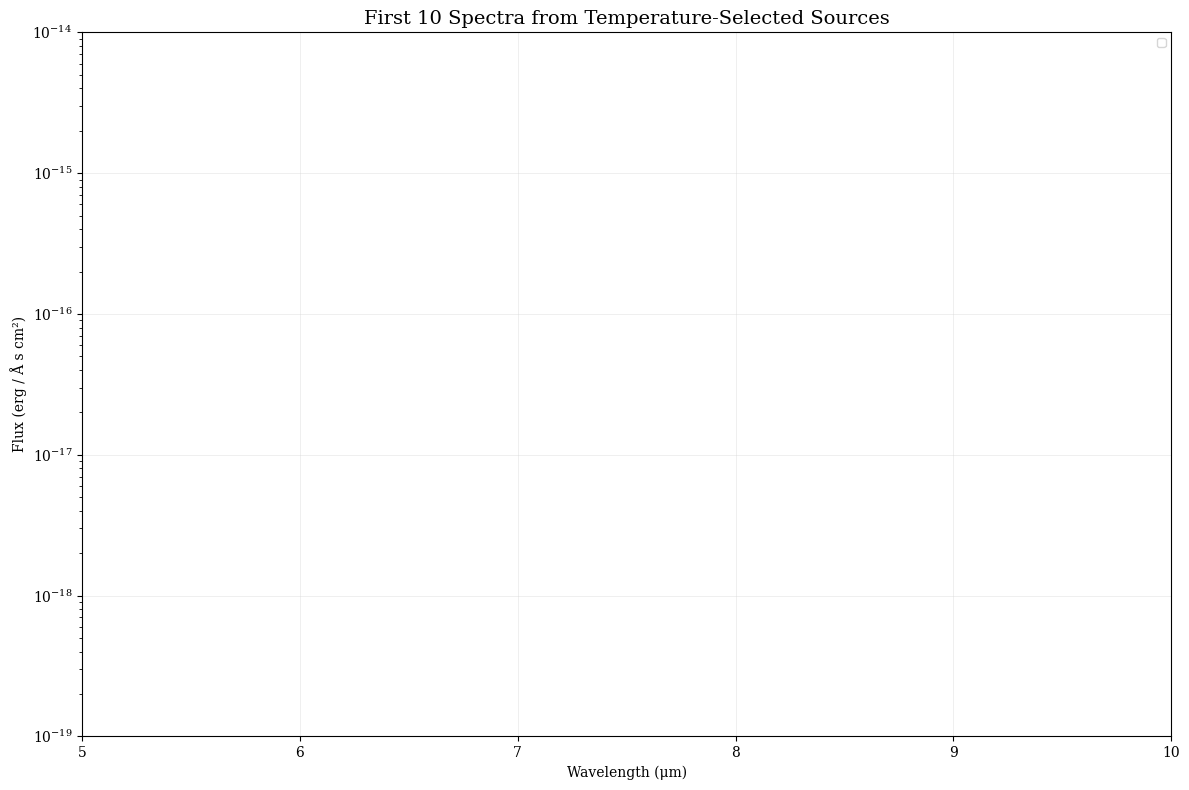

In [48]:
from specutils import Spectrum
import numpy as np

import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const

# Create a figure for plotting
plt.figure(figsize=(12, 8))

# Get the first 10 rows of the dataframe
lower = low_temp[:50]
colors = plt.cm.viridis(np.linspace(0, 1, len(lower)))

# Loop through the first 10 spectra and plot them
for i, (idx, row) in enumerate(lower.iterrows()):
    try:
        # Extract data
        source_name = row['Source']
        temp = row['Teff (K)']
        url = row['URL']
        instrument = row['Instrument']
        regime = row['Regime']
        
        # Load the spectrum
        spec = Spectrum.read(url, format='tabular-fits')
        
        # Get wavelength and flux with units
        wavelength = spec.spectral_axis
        flux = spec.flux
        
        # Convert to common units for plotting
        target_unit = u.erg / (u.s * u.cm**2 * u.AA)
        
        if not flux.unit.is_equivalent(target_unit):
            if flux.unit == u.Jy:
                # Convert from Jansky to erg/s/cm2/Å
                lam = wavelength.to(u.AA)
                fnu = flux.to(u.erg / u.s / u.cm**2 / u.Hz)
                flux = fnu * (const.c.to(u.AA/u.s) / lam**2)
                flux = flux.to(target_unit)
            elif flux.unit == u.W / (u.um * u.m**2):
                flux = flux.to(target_unit)
        
        # Ensure flux is in target unit
        flux = flux.to(target_unit)
        
        # Plot with source name, temperature and instrument in the label
        plt.plot(wavelength, flux, color=colors[i], 
                 label=f"{source_name} (T={temp:.1f}K, {instrument}, {regime})", 
                 alpha=0.8, linewidth=1.5)
        
    except Exception as e:
        print(f"Error: {str(e)}")

# Plot configuration
plt.xlabel("Wavelength (μm)")
plt.ylabel("Flux (erg / Å s cm²)")
plt.title("First 10 Spectra from Temperature-Selected Sources", fontsize=14)
plt.grid(True, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
plt.legend(loc='upper right', fontsize=8)
plt.xlim(5, 10)
plt.ylim(1e-19, 1e-14)

# Use log scale for y-axis if the data spans multiple orders of magnitude
plt.yscale('log')

plt.tight_layout()
plt.show()

AttributeError: 'Table' object has no attribute 'head'

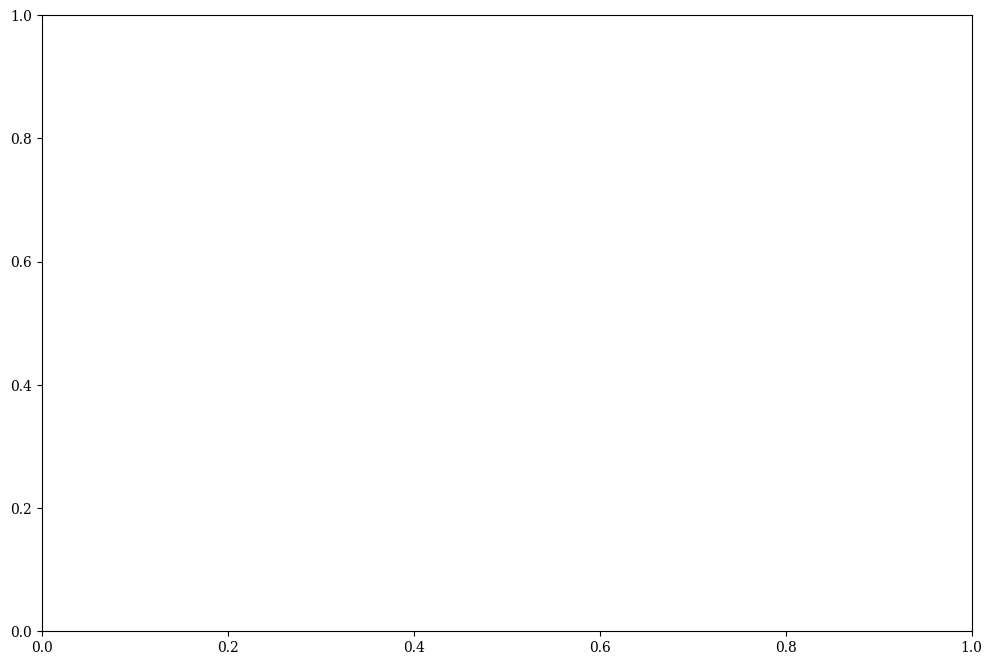

In [17]:
import numpy as np
from specutils import Spectrum

import matplotlib.pyplot as plt
import astropy.units as u

# Define normalization range
l1 = 6.2
l2 = 6.4

# Create a figure
fig, ax = plt.subplots(figsize=(12, 8))

# # List of spectra to process
# spectra_list = [
#     {'data': s0136, 'name': "SIMP J013656.5+093347.3"},
#     {'data': vhs, 'name': "VHS J12560183-1257276"},
#     {'data': {'wavelength': flux_wa, 'flux': flux_fa}, 'name': "WISE 1049A"},
#     {'data': {'wavelength': flux_wb, 'flux': flux_fb}, 'name': "WISE 1049B"}
# ]
# Get the first 10 rows of the dataframe
first_ten = low_temp.head(50)

# Create a colormap for different spectra
colors = plt.cm.viridis(np.linspace(0, 1, len(first_ten)))

# Loop through the first 10 spectra and plot them
for i, (idx, row) in enumerate(first_ten.iterrows()):
    try:
        # Get the spectrum object or wavelength/flux data
        # Extract data
        source_name = row['Source']
        temp = row['Teff (K)']
        url = row['URL']
        instrument = row['Instrument']
        regime = row['Regime']
        
        # Load the spectrum
        spectrum = Spectrum.read(url, format='tabular-fits')
        

        # Handle different data formats
        if isinstance(spectrum, Spectrum):
            wavelength = spectrum.spectral_axis
            flux = spectrum.flux
        else:
            wavelength = spectrum['wavelength']
            flux = spectrum['flux']
        
        # Calculate normalization factor in range l1 to l2
        norm_indices = []
        for i in range(len(wavelength.value)):
            if wavelength.value[i] > l1 and wavelength.value[i] < l2:
                norm_indices.append(i)
                
        if norm_indices:
            norm_factor = np.mean(flux.value[norm_indices])
            normalized_flux = flux / norm_factor
            
            # Plot normalized spectrum
            ax.plot(wavelength, normalized_flux, label=name)
            print(f"Normalized {name} with factor: {norm_factor:.3e}")
        else:
            print(f"Warning: No data points in normalization range for {name}")
            # Plot unnormalized if no points in range
            ax.plot(wavelength, flux, label=f"{name} (unnormalized)")
    
    except Exception as e:
        print(f"Error processing: {str(e)}")

# Configure plot
ax.set_xlim(5.5, 10.5)
ax.set_xlabel('Wavelength (μm)')
ax.set_ylabel('Normalized Flux')
ax.set_title('Normalized Spectra (6.2-6.4 μm)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [ ]:
#plot spectra from one reference 
#plot spectra from within a temperature range

#plot count of spectra by instrument

#plot count of spectra by reference

#plot spectra by obs date

In [54]:
import pandas as pd

# Create a query to join ModeledParameters and Spectra tables

query = """
SELECT 
    mp.source, 
    mp.value as effective_temp, 
    mp.model, 
    s.regime, 
    s.instrument, 
    s.telescope, 
    s.reference as spec_reference,
    mp.reference as temp_reference,
    s.observation_date,
    s.access_url
FROM ModeledParameters mp
JOIN Spectra s ON mp.source = s.source
WHERE mp.parameter = 'radius' 
    AND mp.value BETWEEN 1.0 AND 1.5
ORDER BY mp.value, mp.source, s.regime
"""

# Execute the query
results = db.sql_query(query)

# Create a pandas DataFrame for better display
spectra_df = pd.DataFrame(results, 
                         columns=['Source', 'Radius(Mj)', 'Model', 'Regime', 
                                 'Instrument', 'Telescope', 'Spec_Ref', 
                                 'Param_Ref', 'Obs_Date', 'URL'])

# Display some statistics
print(f"Found {len(spectra_df)} spectra for {spectra_df['Source'].nunique()} unique sources")

# Display the first 10 rows with selected columns for readability
spectra_df.head(50)

Found 1202 spectra for 357 unique sources


,Source,Radius(Mj),Model,Regime,Instrument,Telescope,Spec_Ref,Param_Ref,Obs_Date,URL
0,2MASS J00320509+0219017,1.00,evolutionary,optical,R-C Spec,KPNO 4m,Reid08.1290,Sang23,2003-07-09 00:00:00.000000,https://s3.amazonaws.com/bdnyc/optical_spectra...
1,2MASS J02355993-2331205,1.00,evolutionary,mir,IRS,Spitzer,PID50367,Sang23,2009-01-19 21:59:42.525000,https://s3.amazonaws.com/bdnyc/IRS/GJ1048B.txt
2,2MASS J02355993-2331205,1.00,evolutionary,nir,SpeX,IRTF,Burg08.579,Sang23,2006-12-23 00:00:00.000000,https://s3.amazonaws.com/bdnyc/nir_spectra/U50...
3,2MASS J03255322+0425406,1.00,atmospheric,nir,SpeX,IRTF,Chiu06,Sang23,2005-08-13 00:00:00.000000,https://s3.amazonaws.com/bdnyc/spex-prism_SDSS...
4,2MASS J04455387-3048204,1.00,None,mir,IRS,Spitzer,Suar22,Fili15,2005-03-14 00:00:00.000000,https://bdnyc.s3.amazonaws.com/IRS/2MASS+J0445...
5,2MASS J04455387-3048204,1.00,None,mir,IRS,Spitzer,PID3136,Fili15,2005-03-14 12:24:05.373000,https://s3.amazonaws.com/bdnyc/0445-3048.txt
6,2MASS J04455387-3048204,1.00,None,nir,SpeX,IRTF,Cruz18,Fili15,2004-11-08 00:00:00.000000,https://s3.amazonaws.com/bdnyc/SpeX/Prism/U103...
7,2MASS J04455387-3048204,1.00,None,optical,R-C Spec,CTIO 4m,Cruz03,Fili15,2002-01-25 04:49:10.093000,https://s3.amazonaws.com/bdnyc/RCspec/U10329.fits
8,2MASS J05002100+0330501,1.00,None,nir,XShooter,ESO VLT,Manj16,Fili15,2010-02-05 00:00:00.000000,https://bdnyc.s3.amazonaws.com/xshooter/2M0500...
9,2MASS J05002100+0330501,1.00,None,nir,SpeX,IRTF,Bard14,Fili15,2012-12-27 00:00:00.000000,https://bdnyc.s3.amazonaws.com/SpeX/Prism/2MAS...


Found 2692 sources with both temperature and mass measurements
Temperature range: 437.0K - 3200.0K
Mass range: 0.09MJup - 166.44MJup


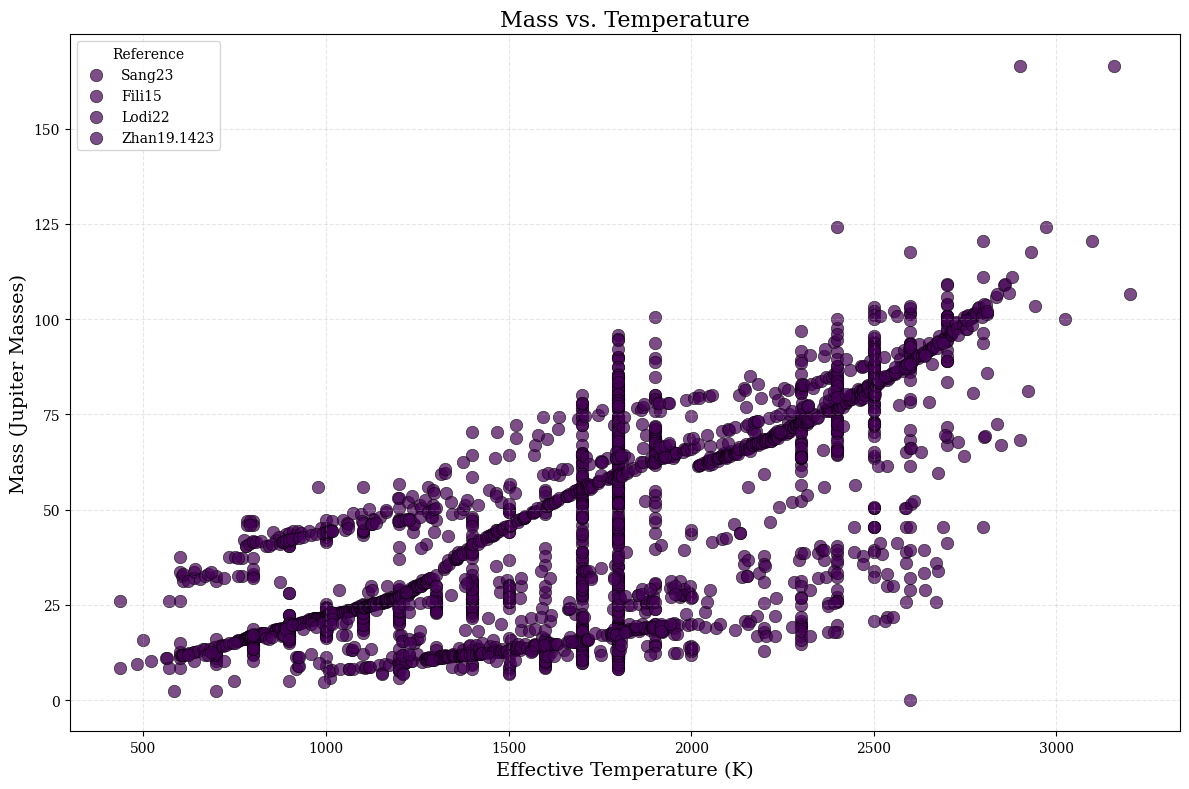

In [52]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Query to find sources that have both temperature and mass measurements
combined_params_query = """
SELECT 
    s1.source, 
    s1.value as temperature, 
    s2.value as mass,
    s1.model as temp_model,
    s2.model as mass_model,
    s1.reference as temp_ref,
    s2.reference as mass_ref
FROM ModeledParameters s1
JOIN ModeledParameters s2 ON s1.source = s2.source
WHERE s1.parameter = 'T eff' AND s2.parameter = 'mass'
ORDER BY s1.value
"""

# Execute the query and store results in a DataFrame
combined_params = db.sql_query(combined_params_query)
params_df = pd.DataFrame(combined_params, 
                        columns=['Source', 'Temperature (K)', 'Mass (MJup)', 
                                 'Temp_Model', 'Mass_Model', 'Temp_Ref', 'Mass_Ref'])

# Display summary information
print(f"Found {len(params_df)} sources with both temperature and mass measurements")
print(f"Temperature range: {params_df['Temperature (K)'].min():.1f}K - {params_df['Temperature (K)'].max():.1f}K")
print(f"Mass range: {params_df['Mass (MJup)'].min():.2f}MJup - {params_df['Mass (MJup)'].max():.2f}MJup")

# Create a scatter plot with custom styling
plt.figure(figsize=(12, 8))

# Create a colormap for different references
unique_refs = params_df['Temp_Ref'].unique()
cmap = plt.cm.viridis
colors = {ref: cmap(i % cmap.N) for i, ref in enumerate(unique_refs)}

# Plot each point with color based on reference
for ref in unique_refs:
    subset = params_df[params_df['Temp_Ref'] == ref]
    plt.scatter(subset['Temperature (K)'], subset['Mass (MJup)'], 
                label=ref, alpha=0.7, edgecolors='black', linewidths=0.5,
                s=80, color=colors[ref])

# Add logarithmic scale for mass
# plt.yscale('log')

# Add labels and title
plt.xlabel('Effective Temperature (K)', fontsize=14)
plt.ylabel('Mass (Jupiter Masses)', fontsize=14)
plt.title('Mass vs. Temperature', fontsize=16)

# Add grid and legend
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(title='Reference', loc='upper left', frameon=True, fontsize=10)

# Show plot with improved formatting
plt.tight_layout()
plt.show()

In [ ]:
## Use plotly or bokeh  to make interactive plots